## Assignment 3 - Identifying spam

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from wordcloud import WordCloud
from collections import Counter

In [2]:
data = pd.read_csv('data.csv')
data.sample(5)

,Class,Message
4739,ham,I bought the test yesterday. Its something tha...
177,ham,U still going to the mall?
3182,ham,So many people seems to be special at first si...
1617,ham,"K, makes sense, btw carlos is being difficult ..."
1278,ham,Dont put your phone on silent mode ok


In [3]:
data.shape

(5574, 2)

### Data exploration

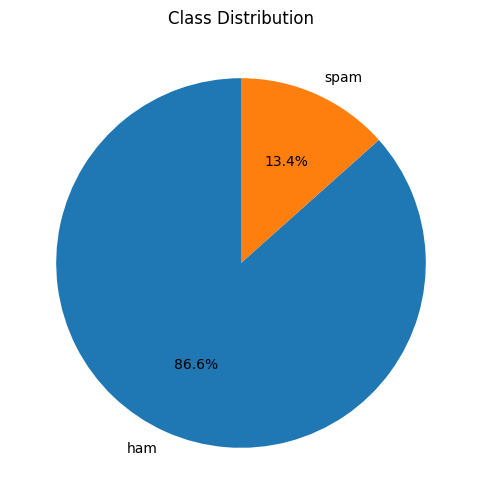

In [4]:
plt.figure(figsize=(10, 6))
plt.pie(data['Class'].value_counts(), labels=data['Class'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()

We can see that there is a lot more `ham` messages than `spam` messages. This could prove tough for our model as it could become biased and miss some of the spams. Therefore we need to remember to adjust the data so that the ratio is more balanced.

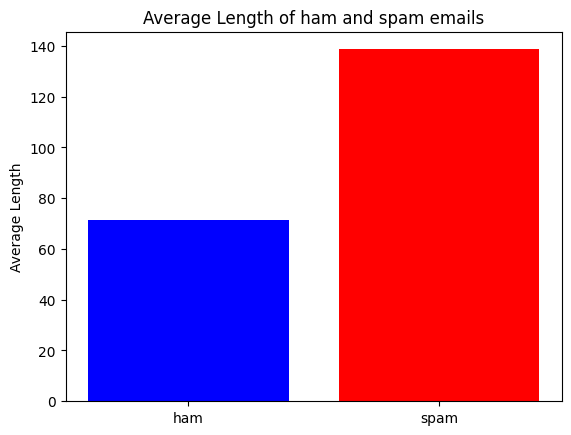

In [5]:
data['Length'] = data['Message'].apply(len)

avg_length_spam = data[data['Class'] == 'spam']['Length'].mean()
avg_length_ham = data[data['Class'] == 'ham']['Length'].mean()

plt.bar(["ham", "spam"], [avg_length_ham, avg_length_spam], color=['blue', 'red'])
plt.title('Average Length of ham and spam emails')
plt.ylabel('Average Length')
plt.show()

### Data pre-processing

From the plot above, we can see that `spam` emails are much longer on average. We created a new column for our data called `Length` as we think that it will help our model with identifying the classes better (more info = better results).

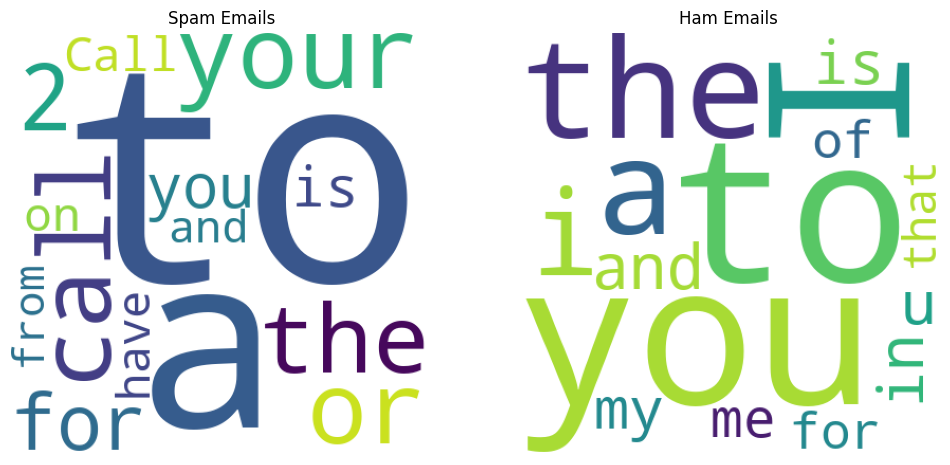

In [6]:
spam_emails = data[data['Class'] == 'spam']
ham_emails = data[data['Class'] == 'ham']

spam_words = ' '.join(list(spam_emails['Message'])).split()
spam_word_counts = Counter(spam_words)
spam_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(spam_word_counts.most_common((15))))

ham_words = ' '.join(list(ham_emails['Message'])).split()
ham_word_counts = Counter(ham_words)
ham_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(ham_word_counts.most_common((15))))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud)
plt.title('Spam Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud)
plt.title('Ham Emails')
plt.axis('off')

plt.show()


In the plots above, we can see that there are multiple words that are frequent in both, spam and ham emails. This could be very confusing for our model so to make it better we will remove those words from all the messages. 

The wordswe will remove (we basically took the ones that look similarly important in both plots): 
- to
- the
- and
- a
- is

In [7]:
stopwords = ['to', 'the', 'and', 'a', 'is']

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

data['transformed_message'] = data['Message'].apply(remove_stopwords)

In [8]:
data.sample(5)

,Class,Message,Length,transformed_message
2071,spam,Sexy Singles are waiting for you! Text your AG...,149,Sexy Singles are waiting for you! Text your AG...
3051,ham,Ok,2,Ok
2395,ham,I don't run away frm u... I walk slowly &amp; ...,96,I don't run away frm u... I walk slowly &amp; ...
3738,ham,Plz note: if anyone calling from a mobile Co. ...,263,Plz note: if anyone calling from mobile Co. &a...
5281,ham,"Helloooo... Wake up..! ""Sweet"" ""morning"" ""welc...",109,"Helloooo... Wake up..! ""Sweet"" ""morning"" ""welc..."


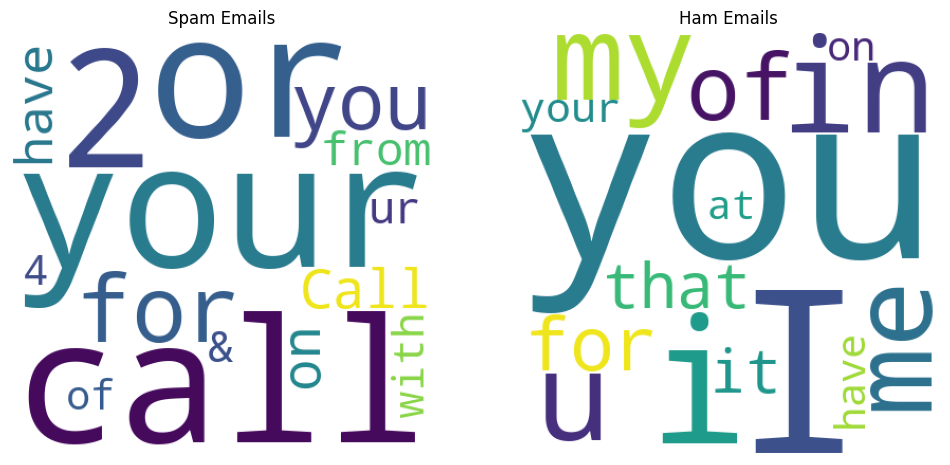

In [9]:
spam_emails = data[data['Class'] == 'spam']
ham_emails = data[data['Class'] == 'ham']

spam_words = ' '.join(list(spam_emails['transformed_message'])).split()
spam_word_counts = Counter(spam_words)
spam_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(spam_word_counts.most_common((15))))

ham_words = ' '.join(list(ham_emails['transformed_message'])).split()
ham_word_counts = Counter(ham_words)
ham_wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(dict(ham_word_counts.most_common((15))))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud)
plt.title('Spam Emails')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud)
plt.title('Ham Emails')
plt.axis('off')

plt.show()

### Model implementation

Lets try to implement the following structure:

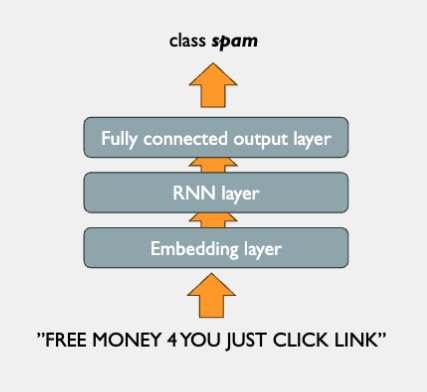

We will implement 2 different versions of the RNN model, one with character embedding and the other with word embedding

#### Character embedding

We want to use embeddings instead of one-hot encoding to camputure relation between words.

In [54]:
messages = []
labels = []

data = data[:1000]

for index, row in data.iterrows():
    messages.append(row['transformed_message'])
    if row['Class'] == 'spam':
        labels.append(1)
    else:
        labels.append(0)

messages = np.array(messages)
labels = np.array(labels)

In [57]:
messages_vec_layer = tf.keras.layers.TextVectorization(split="character")

messages_vec_layer.adapt(messages)
n_tokens = len(messages_vec_layer.get_vocabulary())

print("Number of characters: " + str(n_tokens))

X = messages_vec_layer(messages)
y = labels
y = y.reshape(-1, 1)

print(X.shape)
print(y.shape)


X_train = X[:int(X.shape[0] * .8)]
X_test = X[int(X.shape[0] * .8):]
y_train = y[:int(y.shape[0] * .8)]
y_test = y[int(y.shape[0] * .8):]

Number of characters: 48
(1000, 345)
(1000, 1)
[[0]
 [0]
 [1]
 [0]
 [0]]


Above, we can see that the vectorized messages has been padded so that all have the same length (therefore they can be in the same space and have relation between each other)

In [56]:
embedding = keras.Sequential([
    layers.Embedding(n_tokens, output_dim=1),
])

rnn = keras.Sequential([
    layers.LSTM(128),
    layers.Dense(1, activation="sigmoid")
])

model = keras.Sequential([embedding,rnn])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['f1_score'])

model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - f1_score: 0.2595 - loss: 0.6583 - val_f1_score: 0.2609 - val_loss: 0.4903
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - f1_score: 0.2705 - loss: 0.4798 - val_f1_score: 0.2609 - val_loss: 0.4233
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - f1_score: 0.2500 - loss: 0.4114 - val_f1_score: 0.2609 - val_loss: 0.4257
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - f1_score: 0.2568 - loss: 0.4191 - val_f1_score: 0.2609 - val_loss: 0.4255
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - f1_score: 0.2483 - loss: 0.4112 - val_f1_score: 0.2609 - val_loss: 0.4250
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - f1_score: 0.2590 - loss: 0.4221 - val_f1_score: 0.2609 - val_loss: 0.4230
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - f1_score: 0.2789 - loss: 0.4435 - val_f1_score: 0.2609 - val_loss: 0.4230
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - f1_score: 0.2607 - loss: 0.4239 - val_f1_score: 0.